In [4]:
!pip install  pandas_datareader

     ------------------------------------ 109.5/109.5 kB 636.0 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
#importation de machine learning
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc, roc_auc_score,f1_score,confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifierCV
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier

In [108]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

# Sample code to fetch data (replace with your actual dates and ticker symbols)
nvidia_data = pdr.get_data_yahoo('NVDA', start='2015-01-01', end='2021-01-01')
alphabet_data = pdr.get_data_yahoo('GOOGL', start='2015-01-01', end='2021-01-01')

# Function to calculate RSI
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()        
    gain = 0 * diff
    loss = 0 * diff
    gain[diff > 0] = diff[ diff>0 ]
    loss[diff < 0] = -diff[ diff<0 ]
    avg_gain = gain.ewm(com=window-1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window-1, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Processing NVIDIA Data
nvidia_data['RSI'] = compute_RSI(nvidia_data['Close'])
nvidia_data['50_MA'] = nvidia_data['Close'].rolling(window=50).mean() # 50-day moving average
nvidia_data['200_MA'] = nvidia_data['Close'].rolling(window=200).mean() # 200-day moving average
nvidia_data = nvidia_data.dropna() # Drop rows with NaN values

# Processing Alphabet Data
alphabet_data['RSI'] = compute_RSI(alphabet_data['Close'])
alphabet_data['50_MA'] = alphabet_data['Close'].rolling(window=50).mean()
alphabet_data['200_MA'] = alphabet_data['Close'].rolling(window=200).mean()
alphabet_data = alphabet_data.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [109]:
import pandas as pd
import numpy as np

# Assuming you have your preprocessed NVIDIA and Alphabet data as 'nvidia_data' and 'alphabet_data'

# Function to calculate Exponential Moving Average (EMA)
def EMA(data, period=20, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

# Function to calculate Moving Average Convergence Divergence (MACD)
def MACD(data, period_long=26, period_short=12, period_signal=9):
    ShortEMA = EMA(data, period=period_short)
    LongEMA = EMA(data, period=period_long)
    data['MACD'] = ShortEMA - LongEMA
    data['Signal_Line'] = EMA(data, period=period_signal, column='MACD')
    return data

# Function to calculate Bollinger Bands
def Bollinger_Bands(data, period=20):
    std_dev = data['Close'].rolling(window=period).std()
    data['Middle_Band'] = data['Close'].rolling(window=period).mean()
    data['Upper_Band'] = data['Middle_Band'] + (std_dev * 2)
    data['Lower_Band'] = data['Middle_Band'] - (std_dev * 2)
    return data

def calculate_stochastic_oscillator(data, window=14):
    data['Lowest_low'] = data['Low'].rolling(window=window).min()
    data['Highest_high'] = data['High'].rolling(window=window).max()
    data['Stochastic_oscillator'] = (data['Close'] - data['Lowest_low']) / (data['Highest_high'] - data['Lowest_low']) * 100
    return data.drop(['Lowest_low', 'Highest_high'], axis=1)

def calculate_atr(data, window=14):
    data['High-Low'] = data['High'] - data['Low']
    data['High-Close'] = np.abs(data['High'] - data['Close'].shift())
    data['Low-Close'] = np.abs(data['Low'] - data['Close'].shift())
    data['TR'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=window).mean()
    return data.drop(['High-Low', 'High-Close', 'Low-Close', 'TR'], axis=1)

def calculate_cci(data, window=20):
    tp = (data['High'] + data['Low'] + data['Close']) / 3
    data['CCI'] = (tp - tp.rolling(window=window).mean()) / (0.015 * tp.rolling(window=window).std())
    return data

def calculate_obv(data):
    data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()
    return data


def calculate_parabolic_sar(data):
    data['SAR'] = data['Close'].copy()
    data['EP'] = data['High'].copy() if data['Close'].iloc[0] > data['Open'].iloc[0] else data['Low'].copy()
    data['AF'] = 0.02
    trend = 1 if data['Close'].iloc[0] > data['Open'].iloc[0] else -1

    for i in data.index[1:]:
        if trend == 1:  # Uptrend
            data.at[i, 'SAR'] = max(data.at[data.index[data.index.get_loc(i) - 1], 'SAR'] + data.at[data.index[data.index.get_loc(i) - 1], 'AF'] * (data.at[data.index[data.index.get_loc(i) - 1], 'EP'] - data.at[data.index[data.index.get_loc(i) - 1], 'SAR']), data.at[i, 'Low'])
            if data.at[i, 'High'] > data.at[data.index[data.index.get_loc(i) - 1], 'EP']:
                data.at[i, 'EP'] = data.at[i, 'High']
                data.at[i, 'AF'] = min(data.at[data.index[data.index.get_loc(i) - 1], 'AF'] + 0.02, 0.2)
            if data.at[i, 'Close'] < data.at[i, 'SAR']:
                trend = -1
                data.at[i, 'SAR'] = data.at[data.index[data.index.get_loc(i) - 1], 'EP']
                data.at[i, 'EP'] = data.at[i, 'Low']
                data.at[i, 'AF'] = 0.02
        else:  # Downtrend
            data.at[i, 'SAR'] = min(data.at[data.index[data.index.get_loc(i) - 1], 'SAR'] - data.at[data.index[data.index.get_loc(i) - 1], 'AF'] * (data.at[data.index[data.index.get_loc(i) - 1], 'SAR'] - data.at[data.index[data.index.get_loc(i) - 1], 'EP']), data.at[i, 'High'])
            if data.at[i, 'Low'] < data.at[data.index[data.index.get_loc(i) - 1], 'EP']:
                data.at[i, 'EP'] = data.at[i, 'Low']
                data.at[i, 'AF'] = min(data.at[data.index[data.index.get_loc(i) - 1], 'AF'] + 0.02, 0.2)
            if data.at[i, 'Close'] > data.at[i, 'SAR']:
                trend = 1
                data.at[i, 'SAR'] = data.at[data.index[data.index.get_loc(i) - 1], 'EP']
                data.at[i, 'EP'] = data.at[i, 'High']
                data.at[i, 'AF'] = 0.02

    return data.drop(['EP', 'AF'], axis=1)





nvidia_data = calculate_parabolic_sar(nvidia_data)
alphabet_data = calculate_parabolic_sar(alphabet_data)


nvidia_data = calculate_obv(nvidia_data)
alphabet_data = calculate_obv(alphabet_data)



nvidia_data = calculate_cci(nvidia_data)
alphabet_data = calculate_cci(alphabet_data)



nvidia_data = calculate_atr(nvidia_data)
alphabet_data = calculate_atr(alphabet_data)



nvidia_data = calculate_stochastic_oscillator(nvidia_data)
alphabet_data = calculate_stochastic_oscillator(alphabet_data)


# Apply MACD function
nvidia_data = MACD(nvidia_data)
alphabet_data = MACD(alphabet_data)

# Apply Bollinger Bands function
nvidia_data = Bollinger_Bands(nvidia_data)
alphabet_data = Bollinger_Bands(alphabet_data)

# You can add more indicators as per your analysis requirement

# Dropping any NaN values
nvidia_data = nvidia_data.dropna()
alphabet_data = alphabet_data.dropna()



C:\Users\MSI\AppData\Local\Temp\ipykernel_13832\3261702176.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SAR'] = data['Close'].copy()
C:\Users\MSI\AppData\Local\Temp\ipykernel_13832\3261702176.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EP'] = data['High'].copy() if data['Close'].iloc[0] > data['Open'].iloc[0] else data['Low'].copy()
C:\Users\MSI\AppData\Local\Temp\ipykernel_13832\3261702176.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

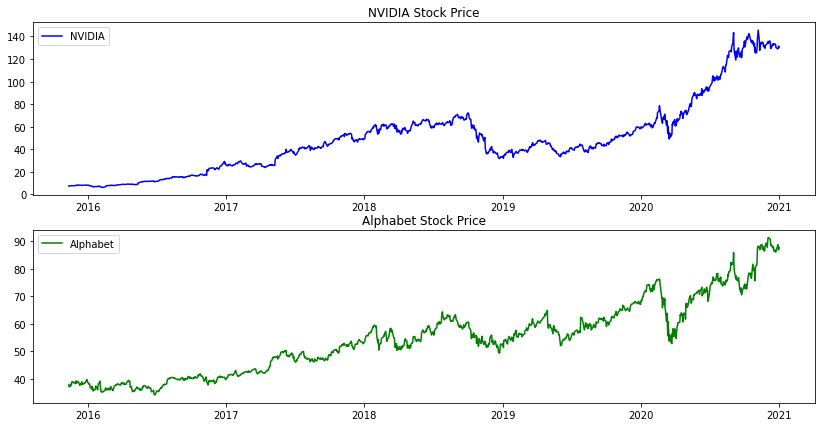

C:\Users\MSI\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\MSI\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


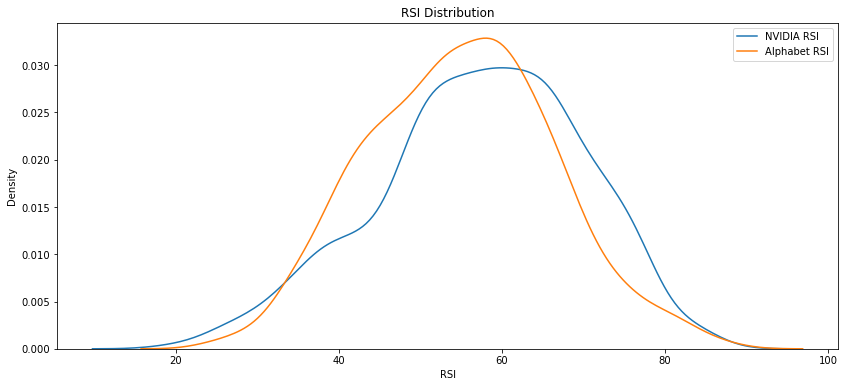

C:\Users\MSI\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\MSI\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


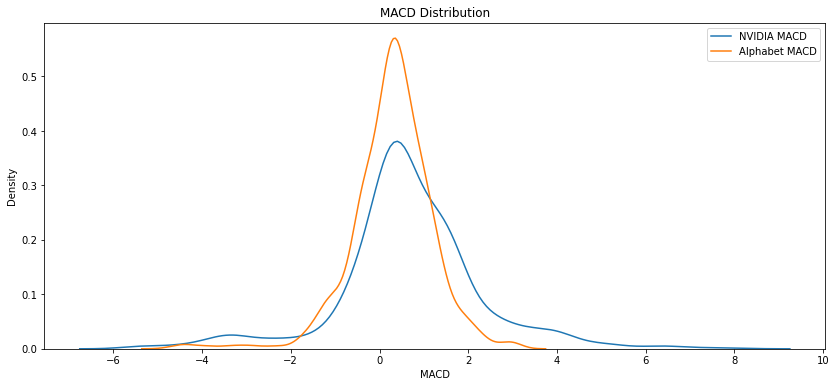

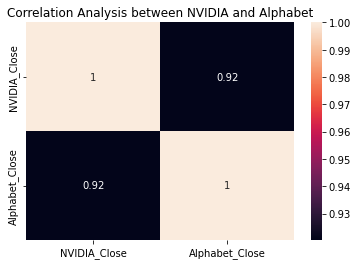

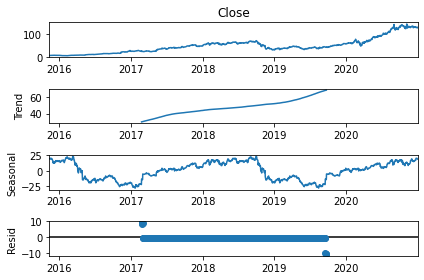

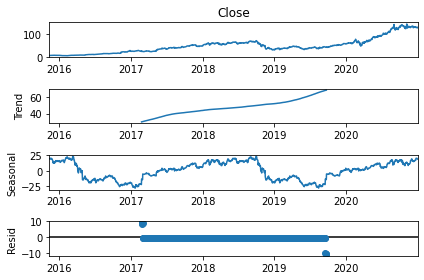

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
#Price Movement Visualization
plt.figure(figsize=(14, 7))
plt.subplot(2,1,1)
plt.plot(nvidia_data['Close'], label='NVIDIA', color='blue')
plt.title('NVIDIA Stock Price')
plt.legend()
plt.subplot(2,1,2)
plt.plot(alphabet_data['Close'], label='Alphabet', color='green')
plt.title('Alphabet Stock Price')
plt.legend()
plt.show()

# RSI Distribution
plt.figure(figsize=(14, 6))
sns.distplot(nvidia_data['RSI'], label='NVIDIA RSI', hist=False)
sns.distplot(alphabet_data['RSI'], label='Alphabet RSI', hist=False)
plt.title('RSI Distribution')
plt.legend()
plt.show()

# MACD Distribution
plt.figure(figsize=(14, 6))
sns.distplot(nvidia_data['MACD'], label='NVIDIA MACD', hist=False)
sns.distplot(alphabet_data['MACD'], label='Alphabet MACD', hist=False)
plt.title('MACD Distribution')
plt.legend()
plt.show()
#Correlation Analysis
combined_data = pd.DataFrame()
combined_data['NVIDIA_Close'] = nvidia_data['Close']
combined_data['Alphabet_Close'] = alphabet_data['Close']

correlation_matrix = combined_data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Analysis between NVIDIA and Alphabet')
plt.show()
#Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Check the number of observations in your data
n_obs = len(nvidia_data)

# Choose a period that is less than half of the number of observations
chosen_period = n_obs // 2 - 1

# Decompose using the adjusted period
nvidia_decomposed = seasonal_decompose(nvidia_data['Close'], model='additive', period=chosen_period)
nvidia_decomposed.plot()
plt.show()

# Check the number of observations in your data
n_obs2 = len(alphabet_data)

# Choose a period that is less than half of the number of observations
chosen_period2 = n_obs2 // 2 - 1

# Decompose using the adjusted period
nvidia_decomposed = seasonal_decompose(nvidia_data['Close'], model='additive', period=chosen_period2)
nvidia_decomposed.plot()
plt.show()




In [111]:


# Selecting features - this is just an example
features = ['Close', 'Volume', 'RSI', 'MACD']



def generate_signals(data):
    # Calculate daily returns (pct_change)
    data['Returns'] = data['Adj Close'].pct_change()
    
    # Generate signals: 1 for buy (positive return), -1 for sell (negative return)
    data['Signal'] = np.where(data['Returns'] > 0, 1, -1)
    
    # Drop the first row with NaN return
   # data.dropna(inplace=True)
    data['Signal']=pd.DataFrame(data['Signal'])
    return data


In [112]:

# Assuming 'nvidia_data' and 'alphabet_data' are your DataFrame with stock prices
nvidia_data = generate_signals(nvidia_data)
alphabet_data = generate_signals(alphabet_data)

In [113]:
nvidia_data.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,50_MA,200_MA,SAR,...,CCI,ATR,Stochastic_oscillator,MACD,Signal_Line,Middle_Band,Upper_Band,Lower_Band,Returns,Signal
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-12,7.6100,7.6800,7.5675,7.6000,7.391409,29108000,65.572332,6.50320,5.667225,7.6800,...,88.013066,0.226429,64.269132,0.173494,0.111309,7.213500,7.867271,6.559729,NaN,-1
2015-11-13,7.6075,7.6400,7.4125,7.4500,7.245526,29294000,60.352281,6.54085,5.680475,7.6400,...,57.251221,0.234107,50.348014,0.163176,0.121683,7.237750,7.888684,6.586816,-0.019737,-1
2015-11-16,7.5475,7.6050,7.4875,7.6000,7.391409,34428000,63.482932,6.58410,5.693950,7.6050,...,64.105427,0.239464,64.269132,0.165199,0.130386,7.270125,7.925715,6.614535,0.020134,1
2015-11-17,7.6200,7.6650,7.5675,7.6000,7.391409,25704800,63.482932,6.62270,5.706812,7.6050,...,67.109482,0.238036,64.269132,0.164901,0.137289,7.303000,7.955349,6.650651,0.000000,-1
2015-11-18,7.6025,7.7675,7.5200,7.7575,7.573234,35021600,66.686244,6.66670,5.720400,7.5675,...,74.805186,0.237143,78.886321,0.175352,0.144902,7.348250,7.994547,6.701953,0.024600,1


In [114]:
nvidia_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI', '50_MA',
       '200_MA', 'SAR', 'OBV', 'CCI', 'ATR', 'Stochastic_oscillator', 'MACD',
       'Signal_Line', 'Middle_Band', 'Upper_Band', 'Lower_Band', 'Returns',
       'Signal'],
      dtype='object')

In [115]:

window_size = 5

# Initialize an empty DataFrame for the scaled values
scaled_nvidia_data = nvidia_data

# Iterate over each column in the DataFrame
for col in ['Volume', 'RSI', '50_MA', '200_MA', 'MACD', 'Signal_Line', 'Middle_Band', 'Upper_Band','Lower_Band', 'SAR', 'OBV', 'CCI', 'ATR', 'Stochastic_oscillator']:
    # Calculate rolling mean and standard deviation
    roll_mean = nvidia_data[col].rolling(window=window_size, min_periods=1).mean()
    roll_std = nvidia_data[col].rolling(window=window_size, min_periods=1).std()

    # Apply mean-standard deviation scaling
    scaled_col = (nvidia_data[col] - roll_mean) / roll_std

    # Handle division by zero (if rolling standard deviation is zero)
    scaled_col[roll_std == 0] = 0  # Or choose another appropriate value

    # Add the scaled column to the scaled DataFrame
    scaled_nvidia_data[col] = scaled_col
    

# Initialize an empty DataFrame for the scaled values
scaled_alphabet_data = alphabet_data

# Iterate over each column in the DataFrame
for col in ['Volume', 'RSI', '50_MA','200_MA', 'MACD', 'Signal_Line', 'Middle_Band', 'Upper_Band','Lower_Band']:
    # Calculate rolling mean and standard deviation
    roll_mean = alphabet_data[col].rolling(window=window_size, min_periods=1).mean()
    roll_std = alphabet_data[col].rolling(window=window_size, min_periods=1).std()

    # Apply mean-standard deviation scaling
    scaled_col = (alphabet_data[col] - roll_mean) / roll_std

    # Handle division by zero (if rolling standard deviation is zero)
    scaled_col[roll_std == 0] = 0  # Or choose another appropriate value

    # Add the scaled column to the scaled DataFrame
    scaled_alphabet_data[col] = scaled_col

In [116]:
scaled_alphabet_data.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,50_MA,200_MA,SAR,...,CCI,ATR,Stochastic_oscillator,MACD,Signal_Line,Middle_Band,Upper_Band,Lower_Band,Returns,Signal
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-12,38.008999,38.290001,37.792999,37.826500,37.826500,NaN,NaN,NaN,NaN,38.453999,...,62.248554,0.583822,74.419125,NaN,NaN,NaN,NaN,NaN,NaN,-1
2015-11-13,37.702000,37.766499,36.973499,37.003502,37.003502,0.707107,-0.707107,0.707107,0.707107,37.766499,...,24.828719,0.588964,35.447349,-0.707107,-0.707107,0.707107,-0.707107,0.707107,-0.021757,-1
2015-11-16,37.010502,37.585499,36.716499,37.521000,37.521000,0.724327,-0.136487,1.026228,1.012203,37.585499,...,21.387568,0.608822,55.369590,-0.851709,-1.151250,1.019411,1.083250,0.990867,0.013985,1
2015-11-17,37.623501,37.747501,37.202499,37.299000,37.299000,-0.607734,-0.541307,1.146305,1.167173,37.533359,...,23.011438,0.611679,38.612882,-1.074883,-1.412305,1.240873,-1.480201,1.334274,-0.005917,-1
2015-11-18,37.478500,38.055000,37.369499,38.000500,38.000500,-0.796859,0.542142,1.274439,1.292039,37.202499,...,43.144476,0.624143,75.896956,-0.853234,-1.416197,1.417378,-1.697926,1.535963,0.018807,1


In [117]:
split_index_nvidia = int(len(nvidia_data) * 0.65)

nvidia_data_train = nvidia_data.iloc[2:split_index_nvidia]
nvidia_data_test = nvidia_data.iloc[split_index_nvidia:]


split_index_alphabet = int(len(alphabet_data) * 0.65)

alphabet_data_train = alphabet_data.iloc[2:split_index_alphabet]
alphabet_data_test = alphabet_data.iloc[split_index_alphabet:]


nvidia_price=nvidia_data_test['Adj Close']
alphabet_price=alphabet_data_test['Adj Close']

In [118]:

# Your target is now the 'Signal' column
nvidia_target = nvidia_data['Signal']
alphabet_target = alphabet_data['Signal']

y_nvidia_train=nvidia_data_train['Signal']
y_alphabet_train=alphabet_data_train['Signal']

y_nvidia_test=nvidia_data_test['Signal']
y_alphabet_test=alphabet_data_test['Signal']

X_nvidia_train=nvidia_data_train
X_nvidia_test=nvidia_data_test


X_alphabet_train=alphabet_data_train
X_alphabet_test=alphabet_data_test

In [119]:
columns_to_drop = ['High', 'Low', 'Close', 'Adj Close','Returns','Signal','Open']
X_nvidia_train.drop(columns=columns_to_drop, inplace=True)
X_nvidia_test.drop(columns=columns_to_drop, inplace=True)

X_alphabet_train.drop(columns=columns_to_drop, inplace=True)
X_alphabet_test.drop(columns=columns_to_drop, inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_13832\3678593100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_nvidia_train.drop(columns=columns_to_drop, inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_13832\3678593100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_nvidia_test.drop(columns=columns_to_drop, inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_13832\3678593100.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [120]:
X_nvidia_train.head()

,Volume,RSI,50_MA,200_MA,SAR,OBV,CCI,ATR,Stochastic_oscillator,MACD,Signal_Line,Middle_Band,Upper_Band,Lower_Band
Date,,,,,,,,,,,,,,
2015-11-16,1.154153,0.132108,1.022258,1.002795,-0.977054,0.710019,-0.351990,0.935706,0.577350,-0.382424,0.969579,1.044252,1.076341,1.003823
2015-11-17,-1.092298,0.120954,1.156200,1.153720,-0.770154,0.598105,-0.151676,0.603516,0.500000,-0.387703,1.079426,1.204734,1.179526,1.226917
2015-11-18,1.094497,1.143359,1.286473,1.269168,-1.225226,1.456532,0.386876,0.405521,1.434654,1.243981,1.202135,1.384522,1.338098,1.423800
2015-11-19,-0.990867,1.049665,1.275377,1.267137,1.609313,1.322494,1.498887,-1.467636,1.057188,1.491256,1.260400,1.272064,1.371649,1.152397
2015-11-20,-0.921162,1.162955,1.278897,1.274527,1.403294,1.302274,1.086407,-1.050079,1.167021,1.376110,1.291190,1.235853,1.380429,0.986901


In [121]:
X_nvidia_test.head()

,Volume,RSI,50_MA,200_MA,SAR,OBV,CCI,ATR,Stochastic_oscillator,MACD,Signal_Line,Middle_Band,Upper_Band,Lower_Band
Date,,,,,,,,,,,,,,
2019-03-19,1.246274,1.412879,1.309168,-1.249855,1.536333,1.360069,0.262671,1.742411,0.733514,1.383350,1.365842,1.350137,1.424121,-1.561440
2019-03-20,0.470255,0.592963,1.220816,-1.270489,1.182127,-0.303369,-0.809557,1.528152,-0.387881,1.239976,1.330779,1.301041,1.297338,-1.286817
2019-03-21,0.782672,1.509572,1.289088,-1.266841,1.193740,1.114005,0.706673,1.497482,1.110821,1.427882,1.363053,1.425144,1.431806,-1.442503
2019-03-22,0.145178,-0.809057,1.261320,-1.288400,1.144863,-0.498524,-1.282157,1.239511,-1.121841,1.104038,1.297897,1.270407,1.211769,-1.083844
2019-03-25,-1.617773,-1.366037,1.198070,-1.292072,1.659853,-1.285211,-1.609969,1.156365,-1.398277,0.655810,1.189681,1.171430,1.045341,-0.650847


In [122]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
  

estimators = [('sgd', SGDClassifier(loss='modified_huber',shuffle=True, random_state=101)),('ada', make_pipeline(StandardScaler(),AdaBoostClassifier(n_estimators=15,learning_rate=0.5))),
               ('rdg', make_pipeline(StandardScaler(),RidgeClassifier())),('knn', make_pipeline(StandardScaler(),KNeighborsClassifier(algorithm='brute', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=55, p=2,
           weights='uniform'))),('logit', make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',C=1.2,solver='liblinear',fit_intercept=True,intercept_scaling=2.1))),('CAT', make_pipeline(StandardScaler(),CatBoostClassifier(iterations=2, learning_rate=1, depth=2)))]

build_lstm_model1= StackingClassifier(estimators=estimators, final_estimator=SVC())
build_lstm_model2= StackingClassifier(estimators=estimators, final_estimator=SVC())    

# Building the model for NVIDIA data
lstm_model_nvidia = build_lstm_model1.fit(X_nvidia_train,y_nvidia_train)

# Building the model for Alphabet data
lstm_model_alphabet = build_lstm_model2.fit(X_alphabet_train,y_alphabet_train)




0:	learn: 0.3393434	total: 2.82ms	remaining: 2.82ms
1:	learn: 0.2733740	total: 8.15ms	remaining: 0us
0:	learn: 0.3371769	total: 1.53ms	remaining: 1.53ms
1:	learn: 0.2632127	total: 5.03ms	remaining: 0us
0:	learn: 0.3407357	total: 3.37ms	remaining: 3.37ms
1:	learn: 0.2769276	total: 7.24ms	remaining: 0us
0:	learn: 0.3440060	total: 3.42ms	remaining: 3.42ms
1:	learn: 0.2766182	total: 7.32ms	remaining: 0us
0:	learn: 0.3430403	total: 1.24ms	remaining: 1.24ms
1:	learn: 0.2745199	total: 2.79ms	remaining: 0us
0:	learn: 0.3394555	total: 3.61ms	remaining: 3.61ms
1:	learn: 0.2756721	total: 9.19ms	remaining: 0us
0:	learn: 0.4397666	total: 2.94ms	remaining: 2.94ms
1:	learn: 0.4105891	total: 7.46ms	remaining: 0us
0:	learn: 0.4383735	total: 1.34ms	remaining: 1.34ms
1:	learn: 0.4100700	total: 2.9ms	remaining: 0us
0:	learn: 0.4439157	total: 3.82ms	remaining: 3.82ms
1:	learn: 0.4180717	total: 7.93ms	remaining: 0us
0:	learn: 0.4356503	total: 3.58ms	remaining: 3.58ms
1:	learn: 0.4128161	total: 7.51ms	remain

In [123]:
nvidia_predictions = build_lstm_model1.predict(X_nvidia_test)
alphabet_predictions = build_lstm_model2.predict(X_alphabet_test)

In [124]:
#nvidia_predictions = np.where(nvidia_predictions == 1, -1, np.where(nvidia_predictions == -1, 1, nvidia_predictions))
alphabet_predictions = np.where(alphabet_predictions == 1, -1, np.where(alphabet_predictions == -1, 1, alphabet_predictions))

In [125]:
initial_investment=100000

Final cash for NVIDIA trading strategy: $113170.12, Profit: $13170.12
Final cash for Alphabet trading strategy: $172394.43, Profit: $72394.43


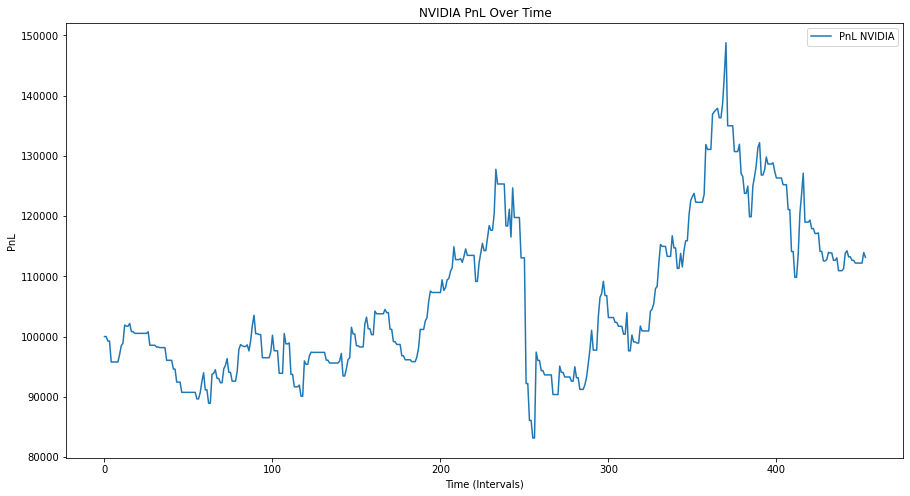

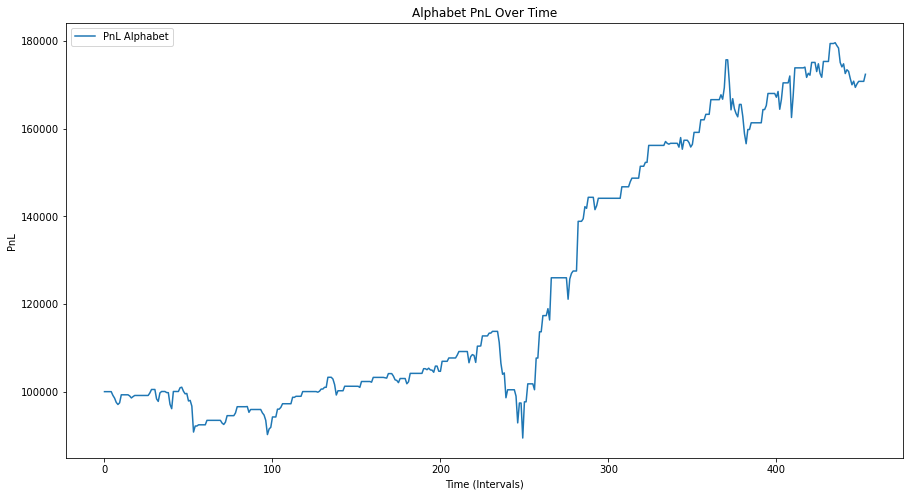

In [126]:
import matplotlib.pyplot as plt
import itertools

# Function to simulate trades and track PnL
def simulate_trades(stock_prices, signals, initial_investment):
    cash = initial_investment
    stock_held = 0
    transaction_log = []
    pnl = [initial_investment]  # Initialize PnL with initial investment

    for i, signal in enumerate(signals):
        # Buy if the model predicts a 'buy' signal
        if signal == 1 and cash >= stock_prices[i]:
            stock_held = cash // stock_prices[i]
            cash -= stock_held * stock_prices[i]
            transaction_log.append(('BUY', i, stock_held, stock_prices[i]))
            
        # Sell if the model predicts a 'sell' signal and stock is held
        elif signal == -1 and stock_held > 0:
            cash += stock_held * stock_prices[i]
            stock_held = 0
            transaction_log.append(('SELL', i, stock_held, stock_prices[i]))
        
        # Update PnL
        current_value = cash + stock_held * stock_prices[i]
        pnl.append(current_value)

    return pnl, transaction_log

# Run the simulation using the closing prices and the predicted signals
pnl_nvidia, transactions_nvidia = simulate_trades(nvidia_price, nvidia_predictions.flatten(), initial_investment)
pnl_alphabet, transactions_alphabet = simulate_trades(alphabet_price, alphabet_predictions.flatten(), initial_investment)

# Calculate final cash and profit for NVIDIA
final_cash_nvidia = pnl_nvidia[-1]
profit_nvidia = final_cash_nvidia - initial_investment

# Calculate final cash and profit for Alphabet
final_cash_alphabet = pnl_alphabet[-1]
profit_alphabet = final_cash_alphabet - initial_investment

# Print the results
print(f"Final cash for NVIDIA trading strategy: ${final_cash_nvidia:.2f}, Profit: ${profit_nvidia:.2f}")
print(f"Final cash for Alphabet trading strategy: ${final_cash_alphabet:.2f}, Profit: ${profit_alphabet:.2f}")

# Plot the PnL for NVIDIA
plt.figure(figsize=(15, 8))
plt.plot(pnl_nvidia, label='PnL NVIDIA')
plt.title('NVIDIA PnL Over Time')
plt.ylabel('PnL')
plt.xlabel('Time (Intervals)')
plt.legend()
plt.show()

# Plot the PnL for Alphabet
plt.figure(figsize=(15, 8))
plt.plot(pnl_alphabet, label='PnL Alphabet')
plt.title('Alphabet PnL Over Time')
plt.ylabel('PnL')
plt.xlabel('Time (Intervals)')
plt.legend()
plt.show()


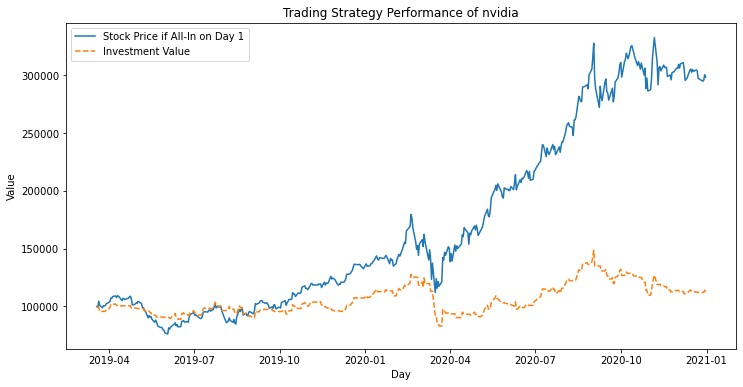

In [127]:
def calculate_cumulative_investment_value(transactions, stock_prices, initial_investment):
    cash = initial_investment
    stock_held = 0
    investment_value = []

    for i, price in enumerate(stock_prices):
        # Execute transactions that occur on this day
        while transactions and transactions[0][1] == i:
            action, _, quantity, _ = transactions.pop(0)
            if action == 'BUY' and cash >= price:
                num_stocks_to_buy = cash // price
                stock_held += num_stocks_to_buy
                cash -= num_stocks_to_buy * price
            elif action == 'SELL' and stock_held > 0:
                cash += stock_held * price
                stock_held = 0

        # Calculate current value of investment
        current_value = cash + stock_held * price
        investment_value.append(current_value)

    return investment_value

cumulative_investment_value = calculate_cumulative_investment_value(transactions_nvidia, nvidia_price, initial_investment)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nvidia_price.index, nvidia_price.values * (initial_investment // nvidia_price.iloc[0]), label='Stock Price if All-In on Day 1')
plt.plot(nvidia_price.index, cumulative_investment_value, label='Investment Value', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Trading Strategy Performance of nvidia')
plt.legend()
plt.show()

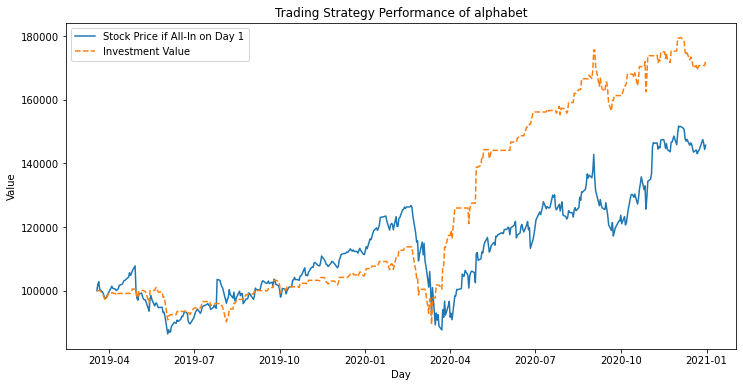

In [128]:
def calculate_cumulative_investment_value(transactions, stock_prices, initial_investment):
    cash = initial_investment
    stock_held = 0
    investment_value = []

    for i, price in enumerate(stock_prices):
        # Execute transactions that occur on this day
        while transactions and transactions[0][1] == i:
            action, _, quantity, _ = transactions.pop(0)
            if action == 'BUY' and cash >= price:
                num_stocks_to_buy = cash // price
                stock_held += num_stocks_to_buy
                cash -= num_stocks_to_buy * price
            elif action == 'SELL' and stock_held > 0:
                cash += stock_held * price
                stock_held = 0

        # Calculate current value of investment
        current_value = cash + stock_held * price
        investment_value.append(current_value)

    return investment_value

cumulative_investment_value = calculate_cumulative_investment_value(transactions_alphabet, alphabet_price, initial_investment)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(alphabet_price.index, alphabet_price.values * (initial_investment // alphabet_price.iloc[0]), label='Stock Price if All-In on Day 1')
plt.plot(alphabet_price.index, cumulative_investment_value, label='Investment Value', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Trading Strategy Performance of alphabet')
plt.legend()
plt.show()

In [129]:
import numpy as np

def evaluate_financial_performance(final_cash, initial_investment, stock_data):
    total_return = (final_cash - initial_investment) / initial_investment
    annualized_return = total_return / (len(stock_data) / 252)  # Assuming 252 trading days in a year

    # Calculating daily returns from stock_data
    daily_returns = stock_data.pct_change()[1:]
    sharpe_ratio = np.mean(daily_returns) / (np.std(daily_returns) * np.sqrt(252))

    return total_return, annualized_return, sharpe_ratio

# Example usage with revised function (assuming nvidia_price and alphabet_price are pandas Series)
total_return_nvidia, annual_return_nvidia, sharpe_ratio_nvidia = evaluate_financial_performance(final_cash_nvidia, initial_investment, nvidia_price)
total_return_alphabet, annual_return_alphabet, sharpe_ratio_alphabet = evaluate_financial_performance(final_cash_alphabet, initial_investment, alphabet_price)

# Print the results
print(f"NVIDIA - Total Return: {total_return_nvidia:.3f}, Annualized Return: {annual_return_nvidia:.3f}, Sharpe Ratio: {sharpe_ratio_nvidia:.3f}")
print(f"Alphabet - Total Return: {total_return_alphabet:.3f}, Annualized Return: {annual_return_alphabet:.3f}, Sharpe Ratio: {sharpe_ratio_alphabet:.3f}")


NVIDIA - Total Return: 0.132, Annualized Return: 0.073, Sharpe Ratio: 0.006
Alphabet - Total Return: 0.724, Annualized Return: 0.403, Sharpe Ratio: 0.003
